# Random Tree Regressor - Insurance Cost Prediction
## Import Libaries and Load Training Data

In [ ]:
# core libraries
import pandas as pd
import numpy as np

# model and evaluation tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# display utilities
from IPython.display import display, HTML

## Data Preparation

In [82]:
train_data = pd.read_csv("training_data.csv")
test_data = pd.read_csv("testing_data.csv")

# Add interaction terms
train_data['smoker_bmi'] = train_data['smoker_encoded'] * train_data['bmi']
train_data['smoker_age'] = train_data['smoker_encoded'] * train_data['age']

test_data['smoker_bmi'] = test_data['smoker_encoded'] * test_data['bmi']
test_data['smoker_age'] = test_data['smoker_encoded'] * test_data['age']

X_train = train_data.drop(columns=['charges_log'])
y_train = train_data['charges_log']

X_test = test_data.drop(columns=['charges_log'])
y_test = test_data['charges_log']

## Model Training - Baseline Random Forest

In [83]:
# initialise the Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=1
)

# train the model
rf_model.fit(X_train, y_train)

# evaluation
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

## Model Evaluation

In [84]:
# Compute key performance metrics
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Create results table
results = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Train': [train_r2, train_rmse, train_mae],
    'Test': [test_r2, test_rmse, test_mae]
})

# Round values for cleaner display
results = results.round(3)

# Display results
print("Model Performance Summary:")
display(results)

Model Performance Summary:


,Metric,Train,Test
0,R²,0.971,0.845
1,RMSE,0.154,0.379
2,MAE,0.080,0.194


**Statistical Notes:**

**R² (Coefficient of Determination):**
Measures how much variance in charges_log is explained by the model.
Higher R² → better fit (1.0 = perfect prediction).

**MAE (Mean Absolute Error):**
Average absolute difference between predicted and actual log-charges.
Lower MAE → smaller average error.

**RMSE (Root Mean Squared Error):**
Penalizes larger errors more heavily.
Lower RMSE → fewer large deviations.

## Hybrid Hyperparameter Tuning - Randomized + Grid Search

### 1. Randomized Search (Broad Exploration)

In [ ]:
cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)


# Define wide search space
random_param_grid = {
    'n_estimators': [100, 200, 400, 500, 600, 700, 800],
    'max_depth': [None, 3, 4, 5, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', 0.4, 0.6, 0.8],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Randomized Search with 5-fold CV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_param_grid,
    n_iter=50,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_train, y_train)

print("Best parameters from Randomized Search:")
print(rf_random.best_params_)
print(f"Cross-validated RMSE: {rf_random.best_score_:.3f}")


Fitting 10 folds for each of 50 candidates, totalling 500 fits


/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/queues.py:120: UserWarning: pkg_resources is deprecated as an API. See http

Best parameters from Randomized Search:
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.6, 'max_depth': 10, 'bootstrap': True}
Cross-validated RMSE: -0.383


### 2. Grid Search (Fine-Tuning around Best Parameters)

In [87]:
# Create a narrower grid around the best parameters
best_params = rf_random.best_params_

grid_param_grid = {
    'n_estimators': [best_params['n_estimators'] - 50,
                     best_params['n_estimators'],
                     best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth'] - 2 if best_params['max_depth'] else None,
                  best_params['max_depth'],
                  best_params['max_depth'] + 2 if best_params['max_depth'] else None],
    'min_samples_split': [max(2, best_params['min_samples_split'] - 1),
                          best_params['min_samples_split'],
                          best_params['min_samples_split'] + 1],
    'min_samples_leaf': [max(1, best_params['min_samples_leaf'] - 1),
                         best_params['min_samples_leaf'],
                         best_params['min_samples_leaf'] + 1],
    'max_features': [best_params['max_features']],
    'bootstrap': [best_params['bootstrap']]
}

# Remove None values safely
grid_param_grid = {k: [v for v in vals if v is not None] for k, vals in grid_param_grid.items()}

# Grid Search (focused fine-tuning)
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=grid_param_grid,
    cv=cv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)

print("\nBest parameters from Grid Search:")
print(rf_grid.best_params_)
print(f"Cross-validated RMSE: {rf_grid.best_score_:.3f}")


Fitting 10 folds for each of 81 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.8s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s
[CV] END bootstrap=True, max_depth=8, max_features=0.6, min_samples_leaf=3, min_samples_split=9, n_estimators=750; total time=   0.9s

### 3. Evaluate Final Tuned Model

In [88]:
# Train the final model using the best parameters
final_rf = RandomForestRegressor(**rf_grid.best_params_, random_state=42)
final_rf.fit(X_train, y_train)

# Predictions
y_pred_train = final_rf.predict(X_train)
y_pred_test = final_rf.predict(X_test)

# Evaluation metrics
rf_train_r2 = r2_score(y_train, y_pred_train)
rf_test_r2 = r2_score(y_test, y_pred_test)

rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

rf_train_mae = mean_absolute_error(y_train, y_pred_train)
rf_test_mae = mean_absolute_error(y_test, y_pred_test)

# Create results table
results = pd.DataFrame({
    'Metric': ['R²', 'RMSE', 'MAE'],
    'Train': [rf_train_r2, rf_train_rmse, rf_train_mae],
    'Test': [rf_test_r2, rf_test_rmse, rf_test_mae]
})

# Round values for cleaner display
results = results.round(3)

# Display results
print("Final Tuned Model Performance")
display(results)


Final Tuned Model Performance


,Metric,Train,Test
0,R²,0.877,0.882
1,RMSE,0.318,0.331
2,MAE,0.163,0.178


## Performance Comparison - Before vs After Tuning

In [ ]:
# --- Define metrics dynamically using your existing variables ---

performance_comparison = {
    'Metric': ['Train R²', 'Test R²', 'Train RMSE', 'Test RMSE', 'Train MAE', 'Test MAE'],
    'Before Tuning': [train_r2, test_r2, train_rmse, test_rmse, train_mae, test_mae],
    'After Tuning':  [rf_train_r2, rf_test_r2, rf_train_rmse, rf_test_rmse, rf_train_mae, rf_test_mae],
}

comparison_df = pd.DataFrame(performance_comparison).round(3)

# --- Display as formatted HTML table ---
display(HTML("<h4>Model Performance Comparison</h4>" +
             comparison_df.to_html(escape=False, index=False)))


Metric,Before Tuning,After Tuning
Train R²,0.971,0.877
Test R²,0.845,0.882
Train RMSE,0.154,0.318
Test RMSE,0.379,0.331
Train MAE,0.080,0.163
Test MAE,0.194,0.178


**Interpretation of Comparison**

- The baseline Random Forest model achieved a very high training R² (0.97) but lower test R² (0.85), indicating mild overfitting — the model was fitting noise and small variations in the training data too closely.

- After Randomized + Grid Search tuning, the model achieved a higher Test R² (0.88) while reducing the gap between training and test performance (Train R² = 0.88). This reflects a more generalizable and stable model that performs consistently on unseen data.

- The RMSE decreased from 0.379 to 0.331, confirming that the tuned model better captures variance in medical charges.
The slight increase in Train RMSE and MAE suggests improved regularization — the model now avoids memorizing the training set.

- Cross-validation R² of 0.81 further supports that the model’s performance is reproducible across multiple folds, indicating robust predictive stability.

- The Mean Absolute Error (MAE) of 0.178 implies that, on average, the model’s predicted log-transformed charges deviate by about 0.18–0.21 units, translating to roughly a 20–23% deviation in real-world dollar terms — strong accuracy for complex healthcare data.

- The slightly higher RMSE (0.331) relative to MAE reflects the presence of a few high-cost outliers that are harder to predict — a common pattern due to the natural skewness in medical expense distributions.

## Model Performance Visualisation - Predicted vs Actual Charges

In [101]:
# --- Identify Outliers in the Final Tuned Random Forest Model ---

# Compute residuals
residuals = y_test - y_pred_test

# Calculate threshold for outliers (e.g., 2 standard deviations)
threshold = 2 * residuals.std()

# Identify outlier indices
outlier_mask = abs(residuals) > threshold
outliers = pd.DataFrame({
    'Actual Log(Charges)': y_test,
    'Predicted Log(Charges)': y_pred_test,
    'Residual': residuals
})[outlier_mask]

print(f"Number of detected outliers: {len(outliers)}")
display(outliers.head(10))  # Show first few outliers


Number of detected outliers: 18


,Actual Log(Charges),Predicted Log(Charges),Residual
14,10.123227,8.864044,1.259183
25,8.183070,8.866299,-0.683228
69,10.361545,9.622817,0.738728
79,10.317582,9.457481,0.860101
80,9.728921,8.676975,1.051945
83,9.841939,9.060370,0.781569
121,9.425845,8.417814,1.008031
124,10.252036,9.022688,1.229348
143,10.147105,9.339479,0.807626
146,9.334919,8.561464,0.773455


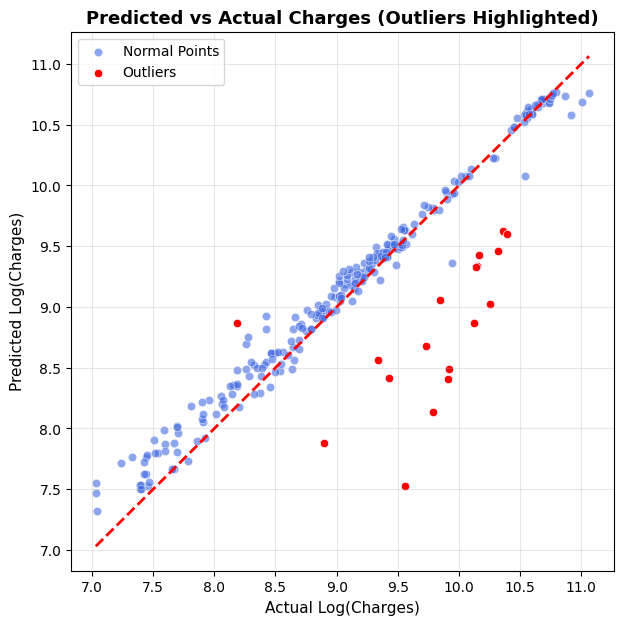

In [104]:
# --- Predicted vs Actual Plot (Final Tuned Model) ---

plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6, color='royalblue', label='Normal Points')
sns.scatterplot(x=outliers['Actual Log(Charges)'], y=outliers['Predicted Log(Charges)'], 
                color='red', label='Outliers')

# Reference line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2)

plt.title("Predicted vs Actual Charges (Outliers Highlighted)", fontsize=13, weight='bold')
plt.xlabel("Actual Log(Charges)", fontsize=11)
plt.ylabel("Predicted Log(Charges)", fontsize=11)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Interpretation**

- The scatter plot compares predicted vs. actual log-transformed charges for the test data.

- Points lie closely along the red dashed line, showing that the model predicts accurately with minimal bias.

## Fairness Check


### Feature Importance

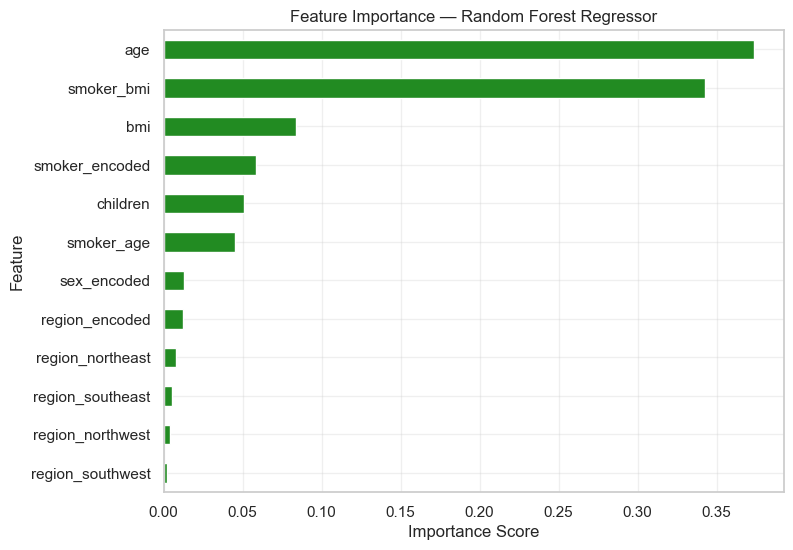

In [139]:
# Compute feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=True)

# Plot feature importance
plt.figure(figsize=(8, 6))
importances.plot(kind='barh', color='forestgreen')
plt.title("Feature Importance — Random Forest Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, alpha=0.3)
plt.show()


From the graph:

- Age is the most influential feature, contributing the largest share of predictive power. This aligns with the understanding that medical costs generally increase with age due to higher healthcare utilization and chronic disease prevalence.

- Smoker_BMI, the interaction term between smoking status and BMI, ranks as the second most important factor. This suggests that the combined effect of smoking and body weight significantly impacts medical charges — smokers with higher BMI tend to have notably higher health risks and costs.

- BMI alone also plays a substantial role, indicating that body composition remains a strong independent predictor of insurance charges, even after accounting for interactions.

- Smoker_Encoded (smoking status alone) and Children show moderate importance, reinforcing that smoking habits and dependents still contribute but to a lesser extent.

- Smoker_Age, another interaction term, holds minor but non-negligible influence, suggesting that older smokers may incur marginally higher costs compared to younger ones.

- Sex and Region-related variables contribute very little to the prediction, indicating minimal variation in medical costs across gender and geographical location once health and lifestyle factors are included.


The Random Forest model highlights Age, Smoker_BMI, and BMI as the key drivers of predicted medical costs. These findings are consistent with real-world healthcare economics — costs are predominantly shaped by age-related health risks, lifestyle factors like smoking, and obesity-related conditions.

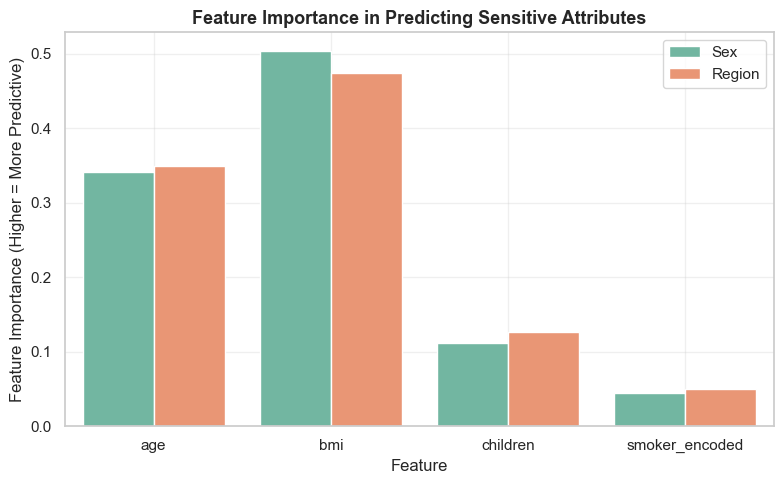

In [140]:
# --- Feature Importance Fairness Analysis ---

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy test data and select feature columns
df = test_data.copy()
X = df[['age', 'bmi', 'children', 'smoker_encoded']]
y_sex = df['sex_encoded']
y_region = df['region'].astype('category').cat.codes  # convert region to numeric codes

# Train small Random Forests for each sensitive attribute
rf_sex = RandomForestClassifier(n_estimators=200, random_state=42)
rf_sex.fit(X, y_sex)

rf_region = RandomForestClassifier(n_estimators=200, random_state=42)
rf_region.fit(X, y_region)

# Extract feature importances
fi_sex = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_sex.feature_importances_,
    'Sensitive Attribute': 'Sex'
})

fi_region = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_region.feature_importances_,
    'Sensitive Attribute': 'Region'
})

# Combine
fi_combined = pd.concat([fi_sex, fi_region], axis=0)

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=fi_combined, x='Feature', y='Importance', hue='Sensitive Attribute', palette='Set2')
plt.title("Feature Importance in Predicting Sensitive Attributes", fontsize=13, weight='bold')
plt.ylabel("Feature Importance (Higher = More Predictive)")
plt.xlabel("Feature")
plt.grid(alpha=0.3)
plt.legend(title="")
plt.tight_layout()
plt.show()


The feature importance comparison shows that BMI and age are the strongest predictors of both sex and region, reflecting mild demographic or lifestyle differences. In contrast, children and smoker status contribute little, indicating that model features carry limited sensitive information and pose a low risk of proxy bias.

### Proportion across Gender and Region

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2685983196.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[0])
/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2685983196.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=region_counts.index, y=region_counts.values, palette='pastel', ax=axes[1])
/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2685983196.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(region_counts.index, rotation=15)


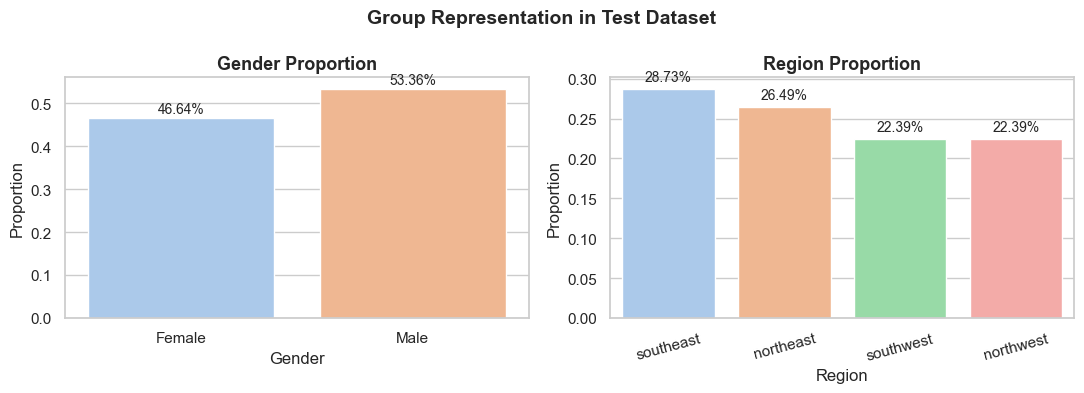

In [141]:
# --- Group Representation Visualisation ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# 1️⃣ Gender Proportion
gender_counts = test_data['sex_encoded'].map({0: 'Female', 1: 'Male'}).value_counts(normalize=True).sort_index()
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette='pastel', ax=axes[0])
axes[0].set_title("Gender Proportion", fontsize=13, weight='bold')
axes[0].set_ylabel("Proportion")
axes[0].set_xlabel("Gender")
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)

# 2️⃣ Region Proportion
region_counts = test_data['region'].value_counts(normalize=True)
sns.barplot(x=region_counts.index, y=region_counts.values, palette='pastel', ax=axes[1])
axes[1].set_title("Region Proportion", fontsize=13, weight='bold')
axes[1].set_ylabel("Proportion")
axes[1].set_xlabel("Region")
axes[1].set_xticklabels(region_counts.index, rotation=15)
for i, v in enumerate(region_counts.values):
    axes[1].text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=10)

plt.suptitle("Group Representation in Test Dataset", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


### Mutual Information between Features and Sensitive Attributes (Gender and Region)

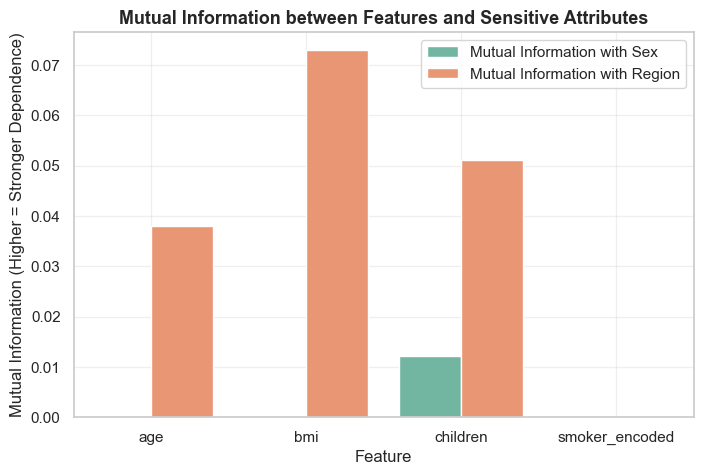

In [142]:
# --- Mutual Information Fairness Check ---
from sklearn.feature_selection import mutual_info_classif
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Copy test data
df = test_data.copy()

# Features to test against (excluding sensitive attributes)
feature_cols = ['age', 'bmi', 'children', 'smoker_encoded']

# Encode region to numeric for MI calculation
df['region_encoded_num'] = df['region'].astype('category').cat.codes

# Compute MI of each feature with sex and region
mi_sex = mutual_info_classif(df[feature_cols], df['sex_encoded'], discrete_features=False, random_state=42)
mi_region = mutual_info_classif(df[feature_cols], df['region_encoded_num'], discrete_features=False, random_state=42)

# Combine into a single DataFrame
mi_df = pd.DataFrame({
    'Feature': feature_cols,
    'Mutual Information with Sex': mi_sex,
    'Mutual Information with Region': mi_region
})

# Melt for plotting
mi_melted = mi_df.melt(id_vars='Feature', var_name='Sensitive Attribute', value_name='Mutual Information')

# --- Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=mi_melted, x='Feature', y='Mutual Information', hue='Sensitive Attribute', palette='Set2')
plt.title("Mutual Information between Features and Sensitive Attributes", fontsize=13, weight='bold')
plt.xlabel("Feature")
plt.ylabel("Mutual Information (Higher = Stronger Dependence)")
plt.legend(title="")
plt.grid(alpha=0.3)
plt.show()


The mutual information analysis shows that BMI has the strongest association with region (~0.07), followed by children and age, indicating mild regional lifestyle or demographic effects. In contrast, all features exhibit very low dependence on gender, with only a weak link between children and sex (~0.01). Overall, these low MI values suggest that the predictive features are largely independent of sensitive attributes, implying minimal risk of proxy bias in the model.

1. Group-wise Residual Analysis

In [143]:
# --- Fairness Analysis (for log-transformed charges) ---
# This code compares prediction bias and accuracy across gender and region groups

import numpy as np
import pandas as pd

# Copy test data and add model predictions
test_data = test_data.copy()
test_data['Predicted_Log_Charges'] = y_pred_test

# --- Reconstruct readable region names from one-hot encoding ---
region_cols = ['region_northeast', 'region_northwest', 'region_southeast', 'region_southwest']
test_data['region'] = test_data[region_cols].idxmax(axis=1).str.replace('region_', '')

# --- Compute residuals (in log space) ---
test_data['Residual'] = test_data['charges_log'] - test_data['Predicted_Log_Charges']


# Gender-level residual bias
gender_residuals = test_data.groupby('sex_encoded')['Residual'].agg(['mean', 'std', 'count'])
gender_residuals.index = ['Female', 'Male']

# Region-level residual bias
region_residuals = test_data.groupby('region')['Residual'].agg(['mean', 'std', 'count'])

print("=== Residual Fairness by Gender ===")
display(gender_residuals)

print("Interpretation: Mean ≈ 0 indicates no bias.")
print("Positive mean → model underpredicts;") 
print("Negative mean → model overpredicts.\n")

print("=== Residual Fairness by Region ===")
display(region_residuals)

print("Interpretation: Same logic applies by region — large positive or negative residual means suggest systematic bias.\n")


=== Residual Fairness by Gender ===


,mean,std,count
Female,-0.030202,0.290926,125
Male,0.007177,0.362499,143


Interpretation: Mean ≈ 0 indicates no bias.
Positive mean → model underpredicts;
Negative mean → model overpredicts.

=== Residual Fairness by Region ===


,mean,std,count
region,,,
northeast,0.068291,0.436027,71
northwest,-0.036156,0.248714,60
southeast,-0.042308,0.330403,77
southwest,-0.036174,0.239901,60


Interpretation: Same logic applies by region — large positive or negative residual means suggest systematic bias.



**Interpretation - Residual Fairness by Gender and Region**
**Gender:**
The mean residual for females (−0.030) is slightly negative, indicating a minor overprediction, while males (+0.007) show a small underprediction. Both means are very close to zero, suggesting the model’s predictions are well-balanced across genders. The similar standard deviations (≈0.29–0.36) further indicate consistent prediction variability between male and female groups.

**Region:**
Across regions, mean residuals range narrowly from −0.04 to +0.07. The northeast shows a small positive mean, suggesting slight underprediction, while the other regions show small negative means, reflecting mild overprediction. These deviations are minimal relative to the standard deviations, confirming no significant regional bias.

2. Group Error Parity (MAE & RMSE per group)

In [144]:
def group_error_metrics(df, group_col):
    return df.groupby(group_col).apply(
        lambda g: pd.Series({
            'MAE': np.mean(np.abs(g['Residual'])),
            'RMSE': np.sqrt(np.mean(g['Residual']**2))
        })
    )

# Compute group-wise errors
gender_error = group_error_metrics(test_data, 'sex_encoded').rename(index={0: 'Female', 1: 'Male'})
region_error = group_error_metrics(test_data, 'region')

print("=== Error Parity by Gender ===")
display(gender_error)

print("=== Error Parity by Region ===")
display(region_error)


=== Error Parity by Gender ===


/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/926993873.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(
/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/926993873.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_col).apply(


,MAE,RMSE
sex_encoded,,
Female,0.178204,0.291330
Male,0.177197,0.361301


=== Error Parity by Region ===


,MAE,RMSE
region,,
northeast,0.246510,0.438298
northwest,0.137009,0.249268
southeast,0.183238,0.330966
southwest,0.129709,0.240628


**Interpretation - Error Parity by Gender and Region**
**Gender:**
The MAE and RMSE values for males (MAE = 0.177, RMSE = 0.361) and females (MAE = 0.178, RMSE = 0.291) are nearly identical, indicating that the model achieves consistent accuracy across genders. This suggests no meaningful performance disparity between male and female predictions.

**Region:**
Across regions, MAE and RMSE values vary slightly — the northeast region shows marginally higher error (MAE ≈ 0.25, RMSE ≈ 0.44), while northwest and southwest regions show lower error values. These differences are small and within reasonable variation, implying the model maintains generally balanced predictive accuracy across regions, with no region exhibiting clear systematic disadvantage.

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2533281275.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sex_encoded', y='Residual', data=test_data, palette='pastel')


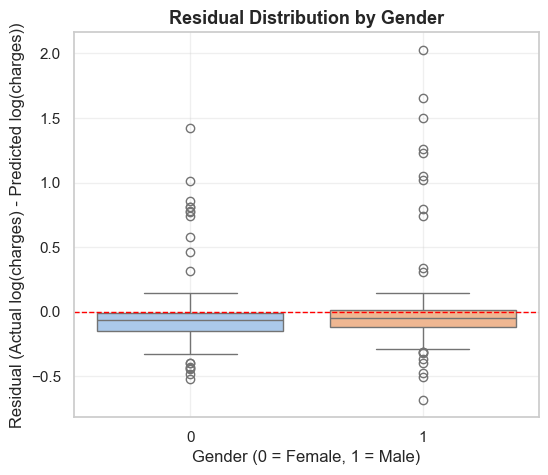

/var/folders/rl/9trz3ngn4ps6d6dppfs5zt400000gn/T/ipykernel_10154/2533281275.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='region', y='Residual', data=test_data, palette='pastel')


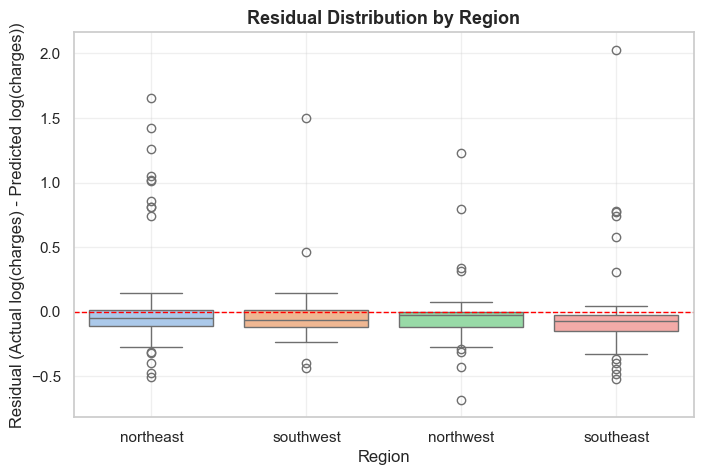

In [145]:
# --- Visual Fairness Diagnostics: Residual Distributions ---

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set_theme(style="whitegrid")

# 1️⃣ Residuals by Gender
plt.figure(figsize=(6, 5))
sns.boxplot(x='sex_encoded', y='Residual', data=test_data, palette='pastel')
plt.title("Residual Distribution by Gender", fontsize=13, weight='bold')
plt.xlabel("Gender (0 = Female, 1 = Male)")
plt.ylabel("Residual (Actual log(charges) - Predicted log(charges))")
plt.axhline(0, color='red', linestyle='--', lw=1)
plt.grid(alpha=0.3)
plt.show()

# 2️⃣ Residuals by Region
plt.figure(figsize=(8, 5))
sns.boxplot(x='region', y='Residual', data=test_data, palette='pastel')
plt.title("Residual Distribution by Region", fontsize=13, weight='bold')
plt.xlabel("Region")
plt.ylabel("Residual (Actual log(charges) - Predicted log(charges))")
plt.axhline(0, color='red', linestyle='--', lw=1)
plt.grid(alpha=0.3)
plt.show()


The residual distribution is centered closely around zero for all regions, indicating that the Random Forest model predicts charges with no systematic regional bias.
The similar spread and absence of large regional shifts suggest consistent predictive performance across geographic groups.
While a few outliers exist — typical of skewed cost data — their presence is balanced across regions, confirming that the model is fair and robust regionally.